In [ ]:
import zipfile
import os

# Unzip into a folder
with zipfile.ZipFile('/content/archive (9).zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [ ]:
!pip install -U albumentations


In [ ]:
import albumentations as A
A.CoarseDropout(max_holes=1, max_height=40, max_width=40, fill_value=0, p=0.5)


/tmp/ipython-input-4-39362076.py:2: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=40, max_width=40, fill_value=0, p=0.5)


CoarseDropout(p=0.5, fill=0.0, fill_mask=None, hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), num_holes_range=(1, 2))

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import albumentations as A
from albumentations.core.composition import OneOf

# --- Step 1: Load and preprocess dataset ---
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if not os.path.isdir(label_folder):
            continue
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                # ✅ Flexible label assignment
                labels.append(0 if 'no' in label.lower() else 1)
    return np.array(images), np.array(labels)

# ✅ Update path to your dataset folder
folder_path = "/content/data/Images"  # <-- Make sure this path exists and has class folders
X, y = load_images_from_folder(folder_path)

# ✅ Sanity check
print(f"✅ Loaded {len(X)} images, class distribution: {np.unique(y, return_counts=True)}")

# ✅ Prevent crash if no data
if len(X) == 0:
    raise ValueError("❌ No images found. Check your dataset path and structure.")

# --- Step 2: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Step 3: Albumentations Augmentation ---
transform = A.Compose([
    OneOf([
        A.MotionBlur(p=0.3),
        A.GaussianBlur(p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3)
    ], p=0.4),
    A.RandomBrightnessContrast(p=0.4),
    A.HorizontalFlip(p=0.5),
    A.CLAHE(p=0.3),
    A.GaussNoise(p=0.2),
    A.CoarseDropout(max_holes=5, max_height=20, max_width=20, fill_value=0, p=0.3),
    A.Normalize(always_apply=True)
])

normalize_only = A.Compose([A.Normalize(always_apply=True)])

# --- Step 4: Custom Data Generator ---
class FaceDataset(tf.keras.utils.Sequence):
    def __init__(self, images, labels, augment=False, batch_size=32):
        self.images = images
        self.labels = labels
        self.augment = augment
        self.batch_size = batch_size
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = []
        for img in self.images[batch_idx]:
            if self.augment:
                img = transform(image=img)['image']
            else:
                img = normalize_only(image=img)['image']
            batch_x.append(img)
        batch_x = np.stack(batch_x)
        batch_y = to_categorical(self.labels[batch_idx], num_classes=2)
        return batch_x, batch_y

# --- Step 5: Build the Model ---
def build_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# --- Step 6: Train the Model ---
train_gen = FaceDataset(X_train, y_train, augment=True)
val_gen = FaceDataset(X_test, y_test, augment=False)

model.fit(train_gen, validation_data=val_gen, epochs=10)

# --- Step 7: Predict on a New Image ---
def predict_glasses(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Unable to read image.")
        return

    img = cv2.resize(img, (224, 224))
    img = normalize_only(image=img)['image']
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    class_names = ["No Glasses", "Glasses"]
    label = class_names[np.argmax(pred)]
    confidence = pred[np.argmax(pred)] * 100

    print(f"🔍 Prediction: {label} ({confidence:.2f}%)")

# --- Example Usage ---
# predict_glasses("/content/sample.jpg")


✅ Loaded 4920 images, class distribution: (array([0, 1]), array([2151, 2769]))


/tmp/ipython-input-14-2396801470.py:57: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=5, max_height=20, max_width=20, fill_value=0, p=0.3),
/tmp/ipython-input-14-2396801470.py:58: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(always_apply=True)
/tmp/ipython-input-14-2396801470.py:61: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  normalize_only = A.Compose([A.Normalize(always_apply=True)])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.5871 - loss: 0.8006 - val_accuracy: 0.9157 - val_loss: 0.2932
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7625 - loss: 0.5187 - val_accuracy: 0.9593 - val_loss: 0.1943
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7973 - loss: 0.4511 - val_accuracy: 0.9715 - val_loss: 0.1425
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8350 - loss: 0.3650 - val_accuracy: 0.9756 - val_loss: 0.1105
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8356 - loss: 0.3662 - val_accuracy: 0.9776 - val_loss: 0.0955
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8637 - loss: 0.3104 - val_accuracy: 0.9787 - val_loss: 0.0818
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8489 - loss: 0.3189 - val_accuracy: 0.9817 - val_loss: 0.0706
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8750 - loss: 0.2959 - val_accu

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import albumentations as A
from albumentations.core.composition import OneOf

# --- Step 1: Load and preprocess dataset ---
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if not os.path.isdir(label_folder):
            continue
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                # ✅ Flexible label assignment
                labels.append(0 if 'no' in label.lower() else 1)
    return np.array(images), np.array(labels)

# ✅ Update path to your dataset folder
folder_path = "/content/data/Images"  # <-- Make sure this path exists and has class folders
X, y = load_images_from_folder(folder_path)

# ✅ Sanity check
print(f"✅ Loaded {len(X)} images, class distribution: {np.unique(y, return_counts=True)}")

# ✅ Prevent crash if no data
if len(X) == 0:
    raise ValueError("❌ No images found. Check your dataset path and structure.")

# --- Step 2: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Step 3: Albumentations Augmentation ---
transform = A.Compose([
    OneOf([
        A.MotionBlur(p=0.3),
        A.GaussianBlur(p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3)
    ], p=0.4),
    A.RandomBrightnessContrast(p=0.4),
    A.HorizontalFlip(p=0.5),
    A.CLAHE(p=0.3),
    A.GaussNoise(p=0.2),
    A.CoarseDropout(max_holes=5, max_height=20, max_width=20, fill_value=0, p=0.3),
    A.Normalize(always_apply=True)
])

normalize_only = A.Compose([A.Normalize(always_apply=True)])

# --- Step 4: Custom Data Generator ---
class FaceDataset(tf.keras.utils.Sequence):
    def __init__(self, images, labels, augment=False, batch_size=32):
        self.images = images
        self.labels = labels
        self.augment = augment
        self.batch_size = batch_size
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = []
        for img in self.images[batch_idx]:
            if self.augment:
                img = transform(image=img)['image']
            else:
                img = normalize_only(image=img)['image']
            batch_x.append(img)
        batch_x = np.stack(batch_x)
        batch_y = to_categorical(self.labels[batch_idx], num_classes=2)
        return batch_x, batch_y

# --- Step 5: Build the Model ---
def build_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# --- Step 6: Train the Model ---
train_gen = FaceDataset(X_train, y_train, augment=True)
val_gen = FaceDataset(X_test, y_test, augment=False)

model.fit(train_gen, validation_data=val_gen, epochs=10)

# --- Step 7: Predict on a New Image ---
def predict_glasses(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Unable to read image.")
        return

    img = cv2.resize(img, (224, 224))
    img = normalize_only(image=img)['image']
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    class_names = ["No Glasses", "Glasses"]
    label = class_names[np.argmax(pred)]
    confidence = pred[np.argmax(pred)] * 100

    print(f"🔍 Prediction: {label} ({confidence:.2f}%)")




# --- Example Usage ---
# predict_glasses("/content/sample.jpg")


✅ Loaded 4920 images, class distribution: (array([0, 1]), array([2151, 2769]))


/tmp/ipython-input-5-2396801470.py:57: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=5, max_height=20, max_width=20, fill_value=0, p=0.3),
/tmp/ipython-input-5-2396801470.py:58: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(always_apply=True)
/tmp/ipython-input-5-2396801470.py:61: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  normalize_only = A.Compose([A.Normalize(always_apply=True)])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.5626 - loss: 0.8419 - val_accuracy: 0.9075 - val_loss: 0.3191
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7730 - loss: 0.5029 - val_accuracy: 0.9441 - val_loss: 0.2037
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8181 - loss: 0.4213 - val_accuracy: 0.9604 - val_loss: 0.1529
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8334 - loss: 0.3673 - val_accuracy: 0.9726 - val_loss: 0.1214
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8398 - loss: 0.3571 - val_accuracy: 0.9715 - val_loss: 0.1038
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8709 - loss: 0.3162 - val_accuracy: 0.9736 - val_loss: 0.0927
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8615 - loss: 0.3061 - val_accuracy: 0.9787 - val_loss: 0.0837
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8686 - loss: 0.2892 - val_accu

In [ ]:
def predict_glasses(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Unable to read image.")
        return

    img = cv2.resize(img, (224, 224))
    img = normalize_only(image=img)['image']
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    class_names = ["No Glasses", "Glasses"]
    label = class_names[np.argmax(pred)]
    confidence = pred[np.argmax(pred)] * 100

    print(f"🔍 Prediction: {label} ({confidence:.2f}%)")


In [ ]:
model.save("/content/mobilenet_glasses_model.h5")  # or use .keras extension


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/mobilenet_glasses_model.h5")


In [ ]:
import matplotlib.pyplot as plt

def predict_glasses(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Unable to read image.")
        return

    img_resized = cv2.resize(img, (224, 224))
    img_norm = normalize_only(image=img_resized)['image']
    img_input = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_input)[0]
    class_names = ["No Glasses", "Glasses"]
    label = class_names[np.argmax(pred)]
    confidence = pred[np.argmax(pred)] * 100

    # Print prediction result
    print(f"🔍 Prediction: {label} ({confidence:.2f}%)")

    # Show image with label
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence:.2f}%)", fontsize=14)
    plt.show()


In [ ]:
predict_glasses('/content/Screenshot 2025-07-11 103816.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
🔍 Prediction: No Glasses (54.98%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔍 Prediction: No Glasses (54.98%)


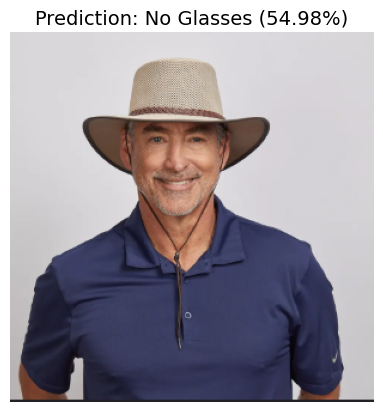

In [ ]:
predict_glasses('/content/Screenshot 2025-07-11 103816.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
🔍 Prediction: No Glasses (50.05%)


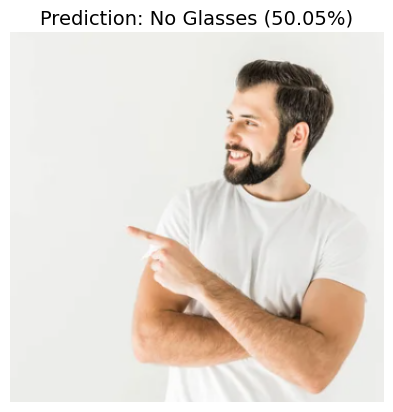

In [ ]:
predict_glasses('/content/Screenshot 2025-07-08 115700.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
🔍 Prediction: No Glasses (50.05%)


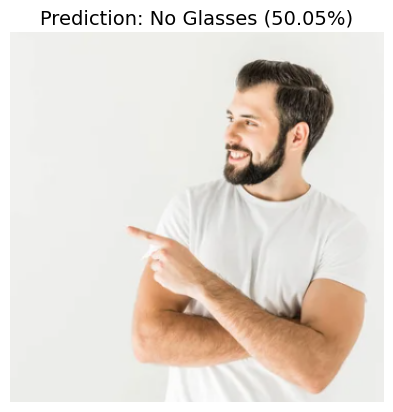

In [ ]:
predict_glasses('/content/Screenshot 2025-07-08 115700.png')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


In [ ]:
def __getitem__(self, index):
    batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
    batch_x = []
    batch_y = []
    for i in batch_idx:
        img = self.images[i]
        try:
            if self.augment:
                img = transform(image=img)['image']
            else:
                img = normalize_only(image=img)['image']
            batch_x.append(img)
            batch_y.append(self.labels[i])
        except Exception as e:
            print(f"⚠️ Skipping image at index {i} due to error: {e}")
            continue
    if len(batch_x) == 0:
        return np.zeros((0, 224, 224, 3)), np.zeros((0, 2))  # Return empty batch
    batch_x = np.stack(batch_x)
    batch_y = to_categorical(batch_y, num_classes=2)
    return batch_x, batch_y


<Figure size 600x600 with 0 Axes>

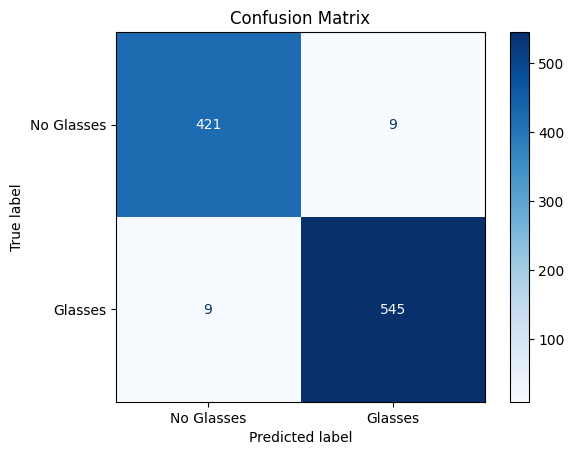


📊 Classification Report:
              precision    recall  f1-score   support

  No Glasses       0.98      0.98      0.98       430
     Glasses       0.98      0.98      0.98       554

    accuracy                           0.98       984
   macro avg       0.98      0.98      0.98       984
weighted avg       0.98      0.98      0.98       984


✅ Test Accuracy: 98.17%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Already have y_true and y_pred from previous confusion matrix step

# 1. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Glasses", "Glasses"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# 2. Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Glasses", "Glasses"]))

# 3. Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


In [ ]:
def __getitem__(self, index):
    batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
    batch_x = []
    batch_y = []
    for i in batch_idx:
        img = self.images[i]
        try:
            if self.augment:
                img = transform(image=img)['image']
            else:
                img = normalize_only(image=img)['image']
            batch_x.append(img)
            batch_y.append(self.labels[i])
        except Exception as e:
            print(f"⚠️ Skipping image at index {i} due to error: {e}")
            continue
    if len(batch_x) == 0:
        return np.zeros((0, 224, 224, 3)), np.zeros((0, 2))  # Return empty batch
    batch_x = np.stack(batch_x)
    batch_y = to_categorical(batch_y, num_classes=2)
    return batch_x, batch_y


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


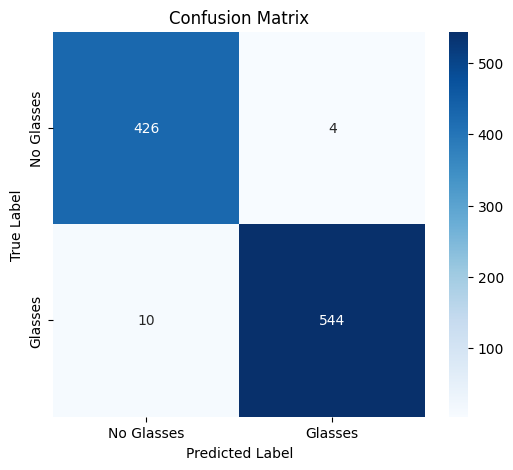


Classification Report:
              precision    recall  f1-score   support

  No Glasses       0.98      0.99      0.98       430
     Glasses       0.99      0.98      0.99       554

    accuracy                           0.99       984
   macro avg       0.98      0.99      0.99       984
weighted avg       0.99      0.99      0.99       984



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on test set
y_test_labels = y_test  # original labels
val_gen_for_eval = FaceDataset(X_test, y_test, augment=False, batch_size=32)
y_pred_probs = model.predict(val_gen_for_eval)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
labels = ["No Glasses", "Glasses"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
🔍 Prediction: Glasses (99.96%)


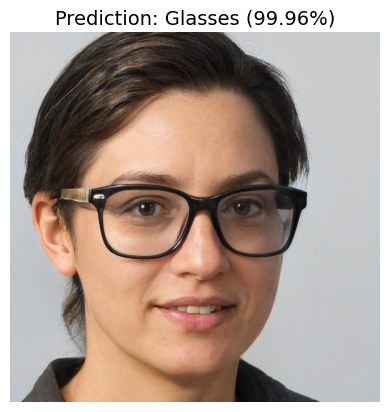

In [ ]:
predict_glasses('/content/data/Images/glasses/face-1001.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
🔍 Prediction: Glasses (99.96%)


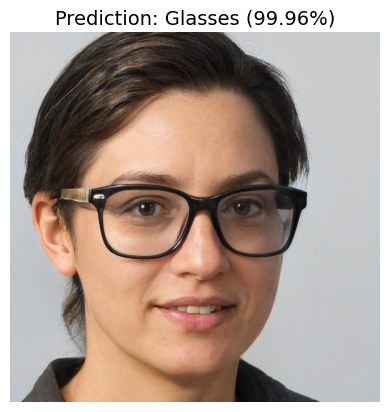

In [ ]:
predict_glasses('/content/data/Images/glasses/face-1001.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
🔍 Prediction: No Glasses (99.37%)


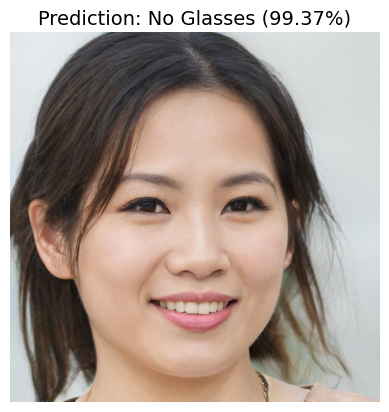

In [ ]:
predict_glasses('/content/data/Images/no_glasses/face-1007.jpg')


In [ ]:
# Evaluate model accuracy on test set
val_gen_eval = FaceDataset(X_test, y_test, augment=False, batch_size=32)
loss, accuracy = model.evaluate(val_gen_eval, verbose=1)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9829 - loss: 0.0560

✅ Test Accuracy: 98.17%


In [ ]:
from sklearn.metrics import accuracy_score

# After generating y_true and y_pred:
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy (from predictions): {acc * 100:.2f}%")



✅ Test Accuracy (from predictions): 98.17%


In [ ]:
# Evaluate on training set
train_gen_eval = FaceDataset(X_train, y_train, augment=False, batch_size=32)
loss, train_accuracy = model.evaluate(train_gen_eval, verbose=1)
print(f"\n✅ Train Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on test set (optional)
val_gen_eval = FaceDataset(X_test, y_test, augment=False, batch_size=32)
loss, test_accuracy = model.evaluate(val_gen_eval, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9893 - loss: 0.0534

✅ Train Accuracy: 98.98%
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9829 - loss: 0.0560
✅ Test Accuracy: 98.17%


In [ ]:
# Evaluate on training set
train_gen_eval = FaceDataset(X_train, y_train, augment=False, batch_size=32)
loss, train_accuracy = model.evaluate(train_gen_eval, verbose=1)
print(f"\n✅ Train Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on test set (optional)
val_gen_eval = FaceDataset(X_test, y_test, augment=False, batch_size=32)
loss, test_accuracy = model.evaluate(val_gen_eval, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9914 - loss: 0.0471

✅ Train Accuracy: 98.98%
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9849 - loss: 0.0587
✅ Test Accuracy: 98.58%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
🔍 Prediction: No Glasses (94.06%)


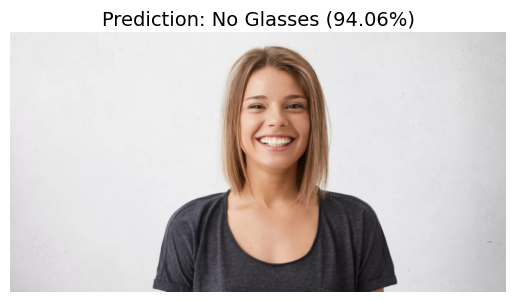

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-23 at 11.23.26_60e19f7a.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔍 Prediction: No Glasses (77.06%)


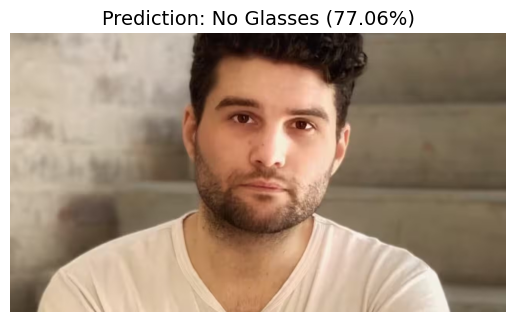

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-23 at 11.22.07_cd704ac8.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
🔍 Prediction: Glasses (69.52%)


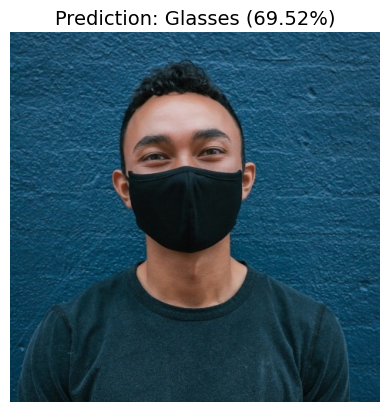

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-23 at 11.20.57_b80c0022.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
🔍 Prediction: Glasses (69.52%)


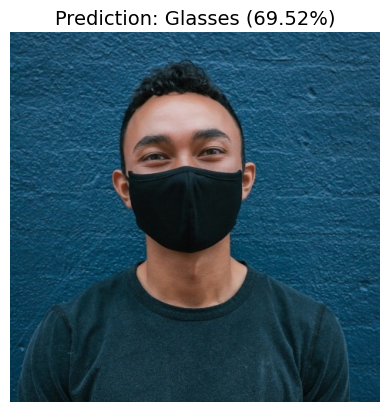

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-23 at 11.20.57_b80c0022.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔍 Prediction: Glasses (87.69%)


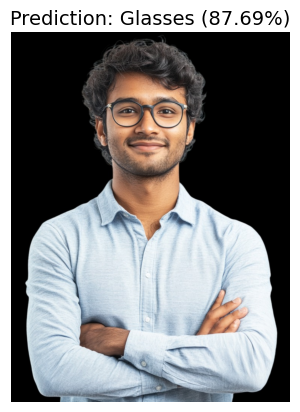

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 23.01.08_7fec90e5.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
🔍 Prediction: Glasses (87.69%)


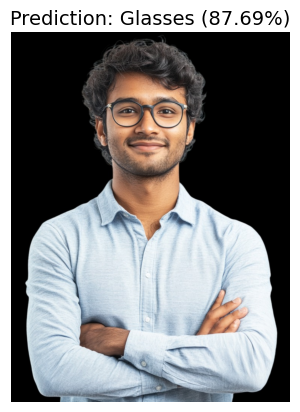

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 23.01.08_7fec90e5.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
🔍 Prediction: Glasses (99.19%)


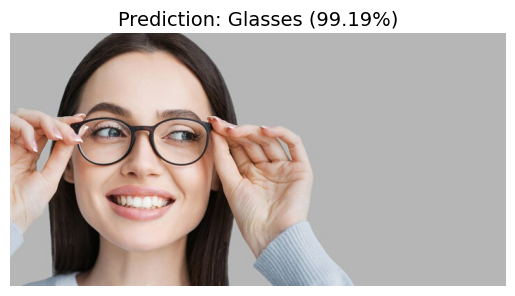

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 23.08.54_135888a8.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
🔍 Prediction: Glasses (97.51%)


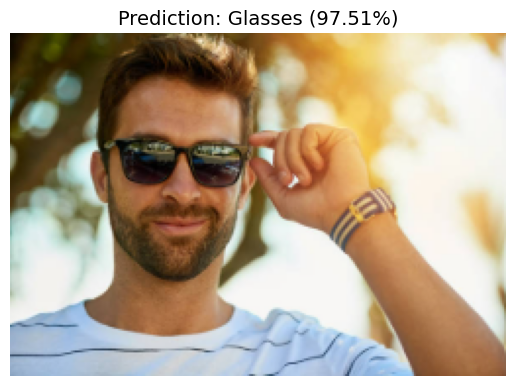

In [ ]:
predict_glasses('/content/Screenshot 2025-07-21 160644.png')

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def predict_glasses(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Unable to read image.")
        return

    img_resized = cv2.resize(img, (224, 224))
    img_norm = normalize_only(image=img_resized)['image']
    img_input = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_input)[0]
    class_names = ["No Glasses", "Glasses"]
    label = class_names[np.argmax(pred)]
    confidence = pred[np.argmax(pred)] * 100

    # Convert BGR to RGB for correct colors in matplotlib
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Display image with prediction
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"🔍 Prediction: {label} ({confidence:.2f}%)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
🔍 Prediction: Glasses (97.47%)


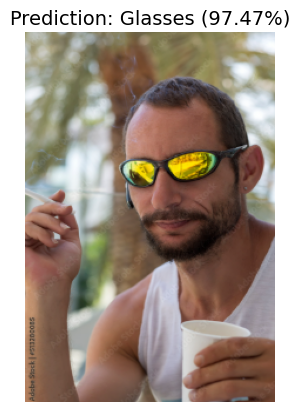

In [ ]:
predict_glasses('/content/Screenshot 2025-07-21 160700.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
🔍 Prediction: No Glasses (88.35%)


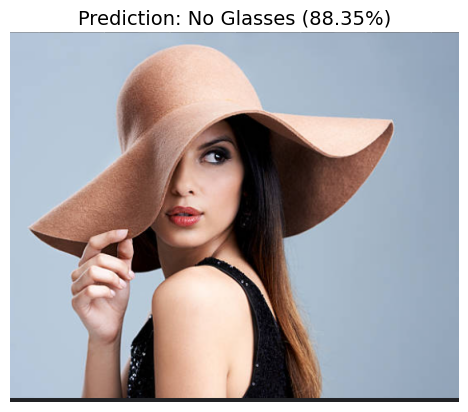

In [ ]:
predict_glasses('/content/Screenshot 2025-07-15 102411.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
🔍 Prediction: Glasses (58.22%)


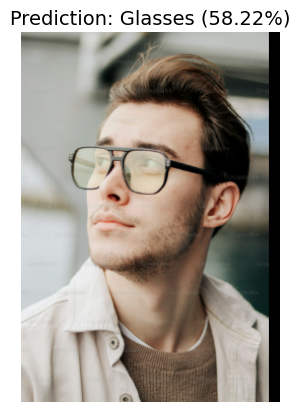

In [ ]:
predict_glasses('/content/Screenshot 2025-07-21 114341.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
🔍 Prediction: No Glasses (83.71%)


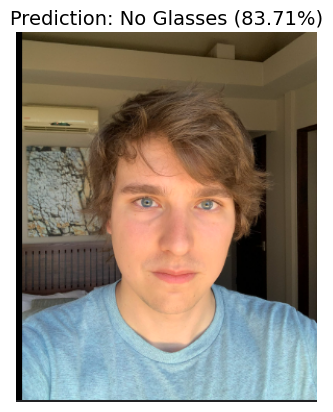

In [ ]:
predict_glasses('/content/c.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔍 Prediction: Glasses (77.19%)


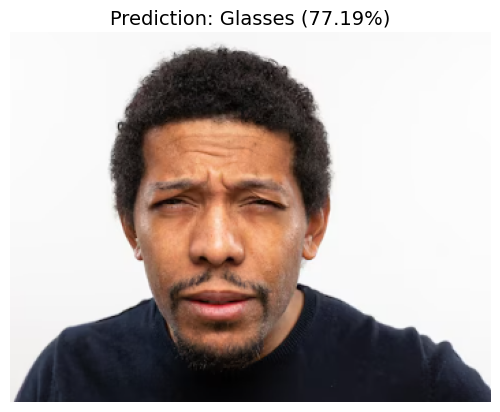

In [ ]:
predict_glasses('/content/d.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
🔍 Prediction: Glasses (77.19%)


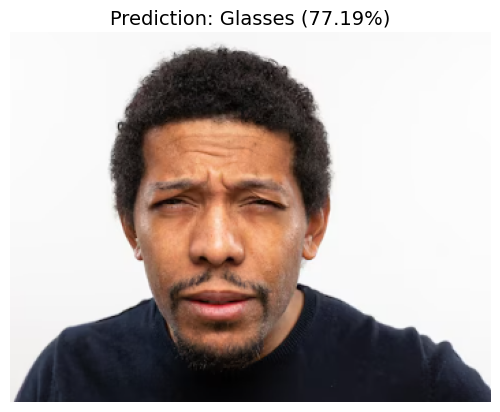

In [ ]:
predict_glasses('/content/d.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
🔍 Prediction: No Glasses (97.96%)


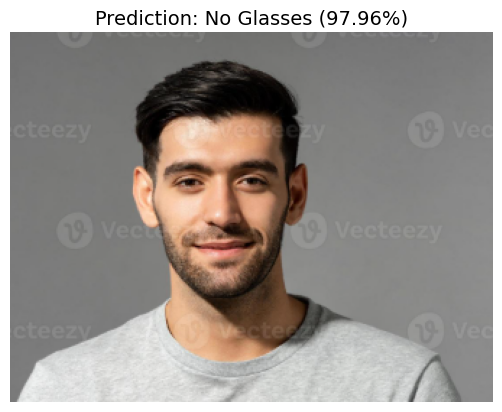

In [ ]:
predict_glasses('/content/ab.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
🔍 Prediction: No Glasses (78.11%)


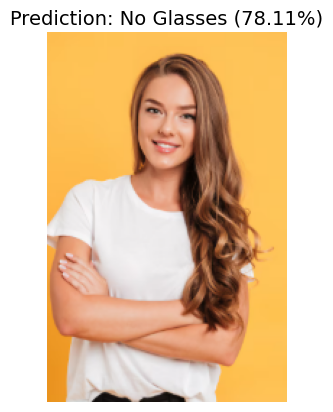

In [ ]:
predict_glasses('/content/abc.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
🔍 Prediction: No Glasses (87.87%)


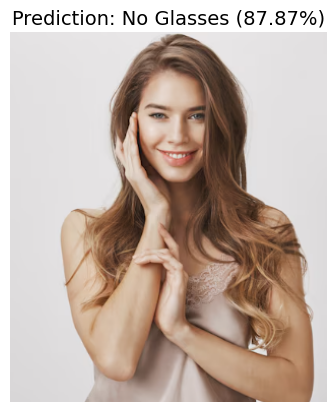

In [ ]:
predict_glasses('/content/abcd.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
🔍 Prediction: No Glasses (93.24%)


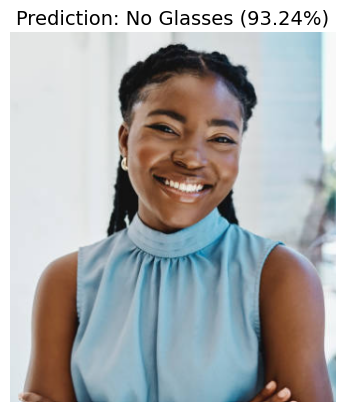

In [ ]:
predict_glasses('/content/ae.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
🔍 Prediction: Glasses (90.21%)


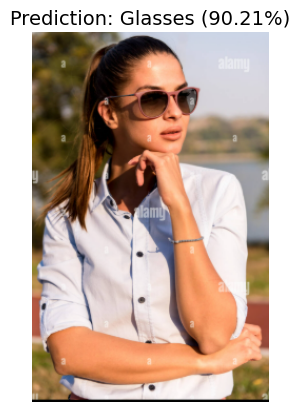

In [ ]:
predict_glasses('/content/aeb.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
🔍 Prediction: No Glasses (89.35%)


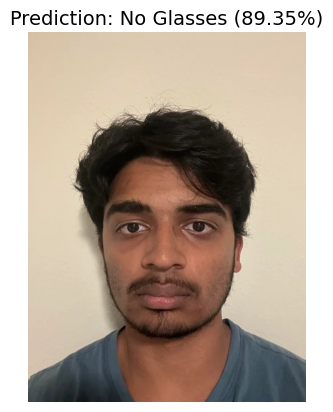

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
🔍 Prediction: No Glasses (50.05%)


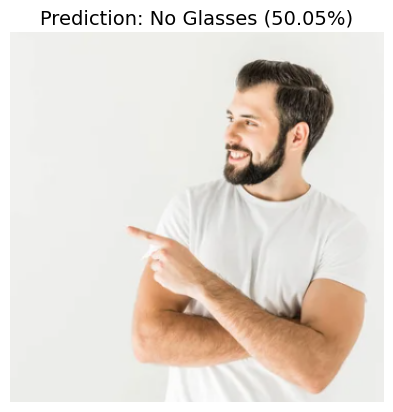

In [ ]:
predict_glasses('/content/Screenshot 2025-07-08 115700.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔍 Prediction: No Glasses (50.05%)


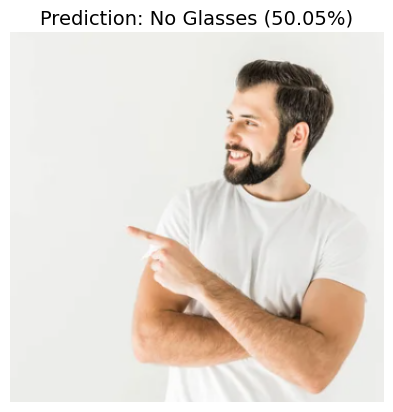

In [ ]:
predict_glasses('/content/Screenshot 2025-07-08 115700.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
🔍 Prediction: No Glasses (89.35%)


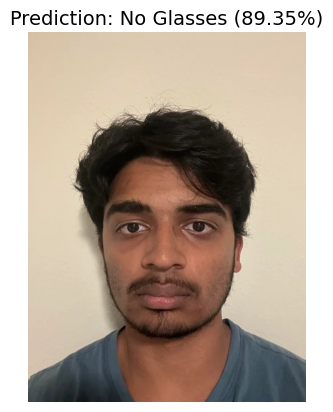

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔍 Prediction: No Glasses (83.71%)


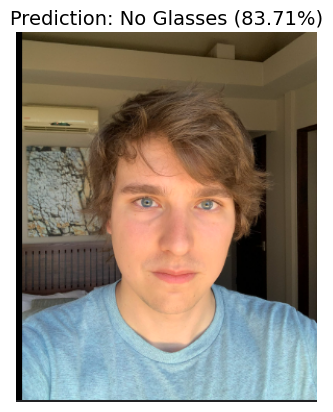

In [ ]:
predict_glasses('/content/c.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
🔍 Prediction: Glasses (87.69%)


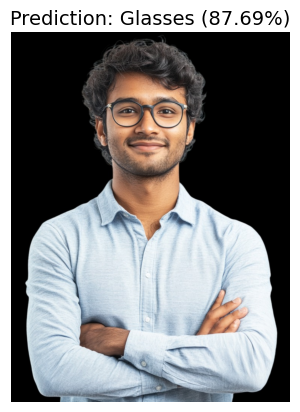

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 23.01.08_7fec90e5.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
🔍 Prediction: No Glasses (88.32%)


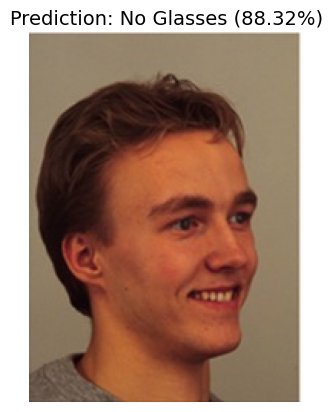

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-07-07 at 12.11.12_b6d19950.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
🔍 Prediction: Glasses (87.48%)


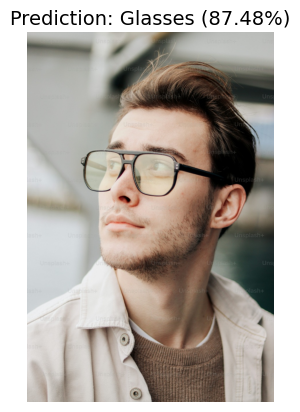

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 22.54.22_61a6fee4.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
🔍 Prediction: Glasses (57.61%)


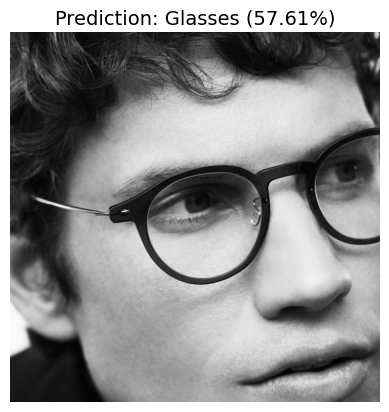

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-24 at 22.58.21_df5a1930.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔍 Prediction: No Glasses (65.83%)


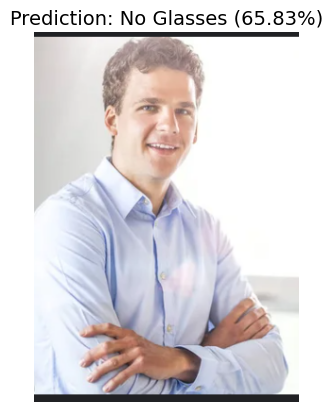

In [ ]:
predict_glasses('/content/Screenshot 2025-07-08 115850.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
🔍 Prediction: Glasses (54.22%)


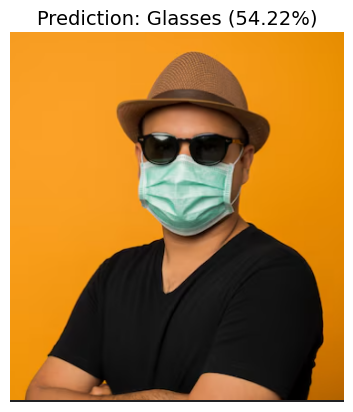

In [ ]:
predict_glasses('/content/Screenshot 2025-07-15 094501.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
🔍 Prediction: Glasses (69.52%)


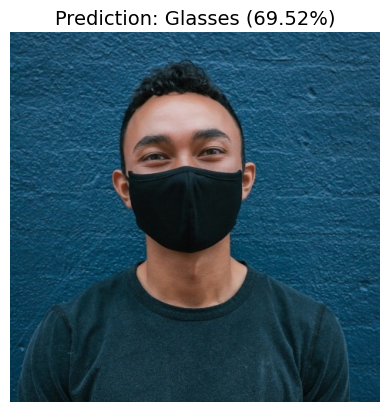

In [ ]:
predict_glasses('/content/WhatsApp Image 2025-06-23 at 11.20.57_b80c0022.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
🔍 Prediction: Glasses (77.19%)


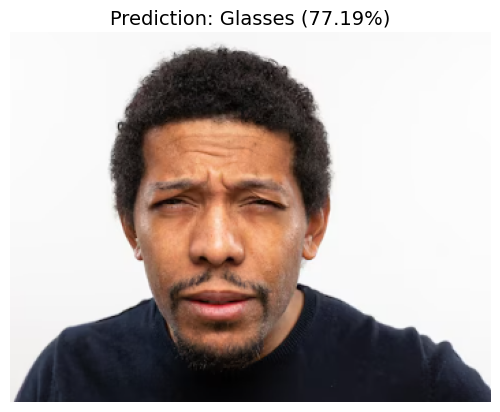

In [ ]:
predict_glasses('/content/d.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
🔍 Prediction: No Glasses (76.90%)


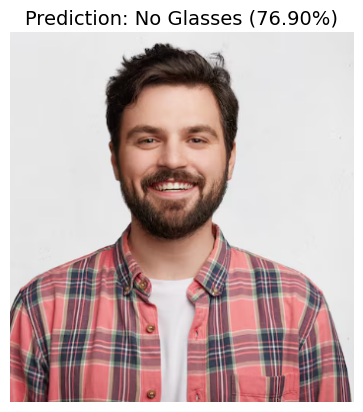

In [ ]:
predict_glasses('/content/this.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
🔍 Prediction: No Glasses (88.80%)


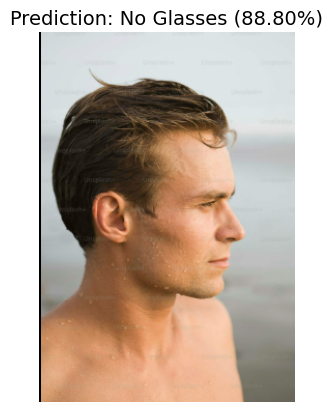

In [ ]:
predict_glasses('/content/this2.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
🔍 Prediction: Glasses (59.40%)


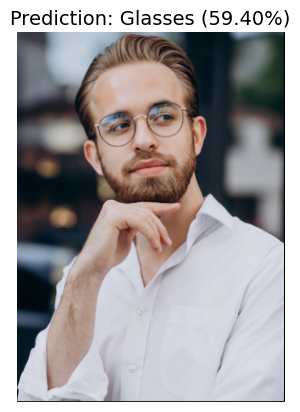

In [ ]:
predict_glasses('/content/a.png')